In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from tqdm import tqdm
sns.set()

In [2]:
def get_vocab(file, lower = False):
    with open(file, 'r') as fopen:
        data = fopen.read()
    if lower:
        data = data.lower()
    vocab = list(set(data))
    return data, vocab

def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data)), dtype = np.int32)
    for i in range(len(data)):
        onehot[i] = vocab.index(data[i])
    return onehot

In [3]:
text, text_vocab = get_vocab('shakespeare.txt', lower = False)
onehot = embed_to_onehot(text, text_vocab)

In [4]:
learning_rate = 0.001
batch_size = 128
sequence_length = 64
epoch = 3000
num_layers = 2
size_layer = 256
possible_batch_id = range(len(text) - sequence_length - 1)

In [5]:
class Model:
    def __init__(
        self, num_layers, size_layer, dimension, sequence_length, learning_rate
    ):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(
                size_layer, sequence_length, state_is_tuple = False
            )

        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell() for _ in range(num_layers)], state_is_tuple = False
        )
        self.X = tf.placeholder(tf.int32, (None, None))
        self.Y = tf.placeholder(tf.int32, (None, None))
        embeddings = tf.Variable(
            tf.random_uniform([len(text_vocab), size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(embeddings, self.X)
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            self.rnn_cells,
            encoder_embedded,
            initial_state = self.hidden_layer,
            dtype = tf.float32,
        )
        self.logits = tf.layers.dense(self.outputs, dimension)
        logits_long = tf.reshape(self.logits, [-1, dimension])
        y_batch_long = tf.reshape(self.Y, [-1])
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = logits_long, labels = y_batch_long
            )
        )
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        self.correct_pred = tf.equal(
            tf.argmax(logits_long, 1), tf.cast(y_batch_long, tf.int64)
        )
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        self.final_outputs = tf.nn.softmax(self.logits)

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), sequence_length, learning_rate)
sess.run(tf.global_variables_initializer())

In [7]:
split_text = text.split()
tag = split_text[np.random.randint(0, len(split_text))]
print(tag)

common


In [8]:
def train_random_batch():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length))
        batch_y = np.zeros((batch_size, sequence_length))
        batch_id = random.sample(possible_batch_id, batch_size)
        for k in range(batch_size):
            batch_x[k] = embed_to_onehot(text[batch_id[k]:batch_id[k]+sequence_length],text_vocab)
            batch_y[k] = embed_to_onehot(text[batch_id[k]+1:batch_id[k]+sequence_length+1],text_vocab)
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

In [9]:
def train_random_sequence():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length))
        batch_y = np.zeros((batch_size, sequence_length))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = [k + n for k in batch_id]
            id2 = [k + n + 1 for k in batch_id]
            batch_x[:,n] = onehot[id1]
            batch_y[:,n] = onehot[id2]
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

In [10]:
LOST, ACCURACY = train_random_sequence()

epoch: 100%|██████████| 3000/3000 [06:31<00:00,  7.66it/s, accuracy=0.611, cost=1.26]


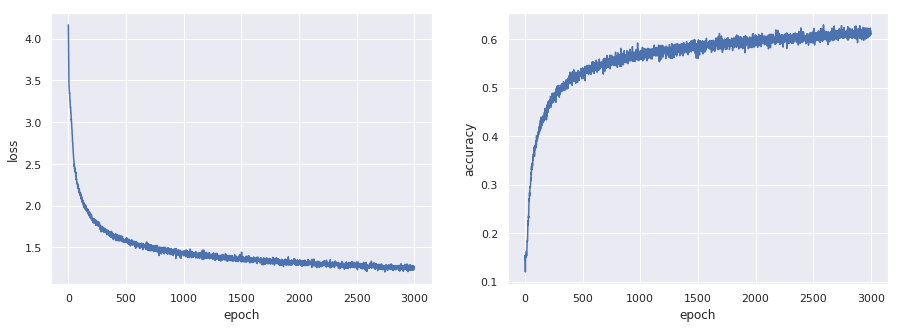

In [11]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [12]:
def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[i]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            char = np.argmax(prob[0][0])
        else:
            char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = text_vocab[char]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[0]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return sentence_generated

In [14]:
print(generate_based_sequence(1000,True))

common boots: yet let him king about
Lends and coutse against home of.

TRUTISA:
Are royal sea from this wine feel'd by himself.

YORK:
Secore thou hast said 'Redian so were hunter sun?

KATHARINA:
Good married! his compovers' insul.

CORIOLANUS:
Should say your son must, not that is gone possess:
withtering wandering villains therefore,
Because there discreeply, Tylanks and the
wight of lossans, Isabel, not the other sits, was by
This seasing sleep back to helps it.
But for, my lord on my poor loathsomety,
But like his bed: I do a trade?
Heaven knows your worship or faith, but
I' my son, to take it stirn; easy one sore
The people or his womper. In it thou shalt
besire your studiates thus all four soul that cares
Nothing being mercing tomborn protecticle?
Our lessings these stames their returns:
To remain that e'er you know what told me?
Fie, sirrah, I kill thee woman, forget to do;
Jook our life winged and ageness will perfect
Is by their eight; he though you are briever.
Go. But, if 

In [15]:
print(generate_based_sequence(1000,False))

common from the crown,
I mean me not, but one yet admit of this meet!

CORIOLANUS:
Not to London get him within the people
Of entertain, has not in post straight.

DUKE OF YORK:
How fie the orace of Exeter; will not
To know you to frop both a heavier true.

JULIET:
What have you march. Romeo my corse?
What is the queen the world is miss for this,
Fight it wold beholding contents.

CAMILLO:
Why
so do?

BRUTUS:
Yet a man quite unesty woached pride?
Doth you bace, his worthy as word out: now
I will bring the hatrest sea, and for me anon
My powers, so hinder like that back to teach:
For honest straight, the sight of this house
And swares me with praise a daggers: itsell'd;
For well straight their birdestments, then abstatter:
If which world they see him says, and we should to
sulmot's chasbe, seath coming the reasons of my kind,
I kneel the wonderers' a man
Affection, we him convey harmoofs,
Pity Clarence will he not much odd;
Must come hither.

COMINIUS Xague:
I tribunes shall eat weet wo